   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7018e-03                                    9.27e-03    
       1              2         8.4825e-03      2.19e-04       3.97e-01       5.72e-04    
       2              3         8.4024e-03      8.01e-05       5.49e-01       2.42e-04    
       3              4         8.3956e-03      6.77e-06       7.86e-02       2.38e-04    
       4              5         8.3929e-03      2.74e-06       3.58e-02       9.49e-05    
       5              6         8.3928e-03      5.88e-08       5.03e-03       9.70e-06    
       6              7         8.3928e-03      5.57e-09       1.14e-03       2.87e-06    
       7              8         8.3928e-03      1.11e-10       2.25e-04       3.86e-07    
       8              9         8.3928e-03      4.60e-12       5.10e-05       1.39e-07    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 8.7018e-03

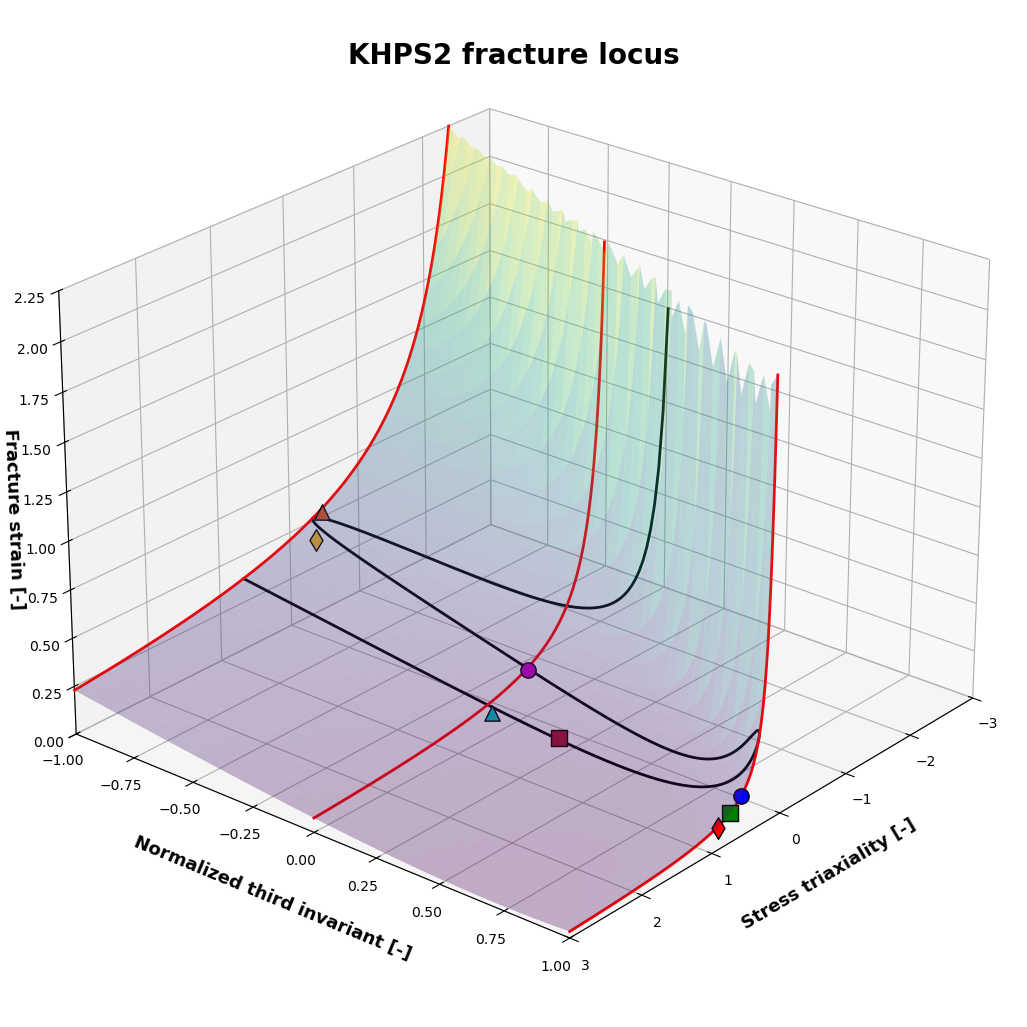

In [599]:
    # Library and package import
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from package.KHPS2_function import KHPS2_function          # Package function
from package.Locus_calculation import locus_calculation    # Package function

# ---------------------------------------------------------------------------------------------------------------------
#                                                  INPUTS
# ---------------------------------------------------------------------------------------------------------------------
    # Definition of aproximation points (measured values of each specimen) - Input for the KHPS2_function
    # List format: [Fracture strain / Stress triaxiality / Normalized third invariant]
specimen_data = {"specimen1": [0.206, 0.583, 1],                   
                 "specimen2": [0.153, 0.745, 1],
                 "specimen3": [0.115, 0.917, 1],
                 "specimen4": [0.154, 0.623, 0.031],
                 "specimen5": [0.244, 0.001, 0.003],
                 "specimen6": [0.133, 0.543, 0.279],
                 "specimen7": [0.417, -0.295, -0.975],
                 "specimen8": [0.588, -0.270, -0.942]}

    # Initial estimated material parameters (unknown - investigated values) - Input for the KHPS2_function
initial_G = np.array([-0.15, 1.15, 2.12, 0.09, 0.94, 0.28])

    # Boundaries of the investigated G1,... G6 material parameters
lower_bounds = np.array([-1, 0, 0, 0, 0, 0])
upper_bounds = np.array([2, 2, 3, 2, 2, 2])

    # scipy.optimize.least_squares option inputs
optimization_options = {
    'ftol': 1e-8,          # Tolerance for the change in the sum of squares of residuals.
    'xtol': 1e-8,          # Tolerance for the change in the optimization variables (G parameters).
    'max_nfev': 10000,     # Maximum number of function evaluations.
    'verbose': 2}          # Display iteration output: 0 (silent), 1 (final report), 2 (each iteration).
    # Numerical stability constant for prevention of division by zero
denominator_epsilon = 1e-6
    # Max fracture strain limit
plot_z_axis_limit = 2.25

# ---------------------------------------------------------------------------------------------------------------------
#                                                  CALCULATION
# ---------------------------------------------------------------------------------------------------------------------
    # The least squares optimization method run function - Minimizes residuals and returns material parameters G1,... G6
result = least_squares(lambda G_params: KHPS2_function(G_params, specimen_data),
                       initial_G, bounds=(lower_bounds, upper_bounds),
                       **optimization_options)

    # Final LSM results (Material parameters - KHPS2_function's unknown values)
G1, G2, G3, G4, G5, G6 = result.x
print("\n" + "-" * 56 + "  Results  " + "-" * 56 + "")
print(f"Calibrated material parameters:\tG1: {G1:7.5f},\tG2: {G2:7.5f},\tG3: {G3:7.5f},\tG4: {G4:7.5f},\tG5: {G5:7.5f},\tG6: {G6:7.5f}\n")

    # Mesh matrix creation (Stress triaxiality - Normalized third invariant)
Y_invar = np.linspace(-1, 1, 999)                   # Normalized third invariant - y coordinate
X_tri = np.linspace(-3, 3, 999)                     # Stress triaxiality - x coordinate
x_tri, y_invar = np.meshgrid(X_tri, Y_invar)        # Grid mesh creation

    # Locus cut-off plane stress triaxiality and fracture stain calculation
tri_c, ef = locus_calculation(result.x, x_tri, y_invar, denominator_epsilon)
ef[x_tri < tri_c] = np.nan             # Fracture strain suppression behind cut-off plane
ef[ef < 0] = np.nan                    # Fracture strain suppression below 0 Z-coordinate
ef[ef > plot_z_axis_limit] = np.nan    # Fracture strain suppression above Z axis limit

    # Calculation of the plane stress curve
tri1 = np.linspace(-2/3, 2/3, 999)           # Plane stress state -  triaxiality
invar1 = -27/2. * tri1 * (tri1**2 - 1/3)     # Plane stress state - normalized third invariant
    # Plane stress cut-off plane stress triaxiality and fracture stain calculation
tri_c1, ef1 = locus_calculation(result.x, tri1, invar1, denominator_epsilon)
ef1[ef1 < 0] = np.nan                     # Fracture strain suppression below 0 Z-coordinate
ef1[ef1 > plot_z_axis_limit] = np.nan     # Fracture strain suppression above Z axis limit

    # Measured specimens value assignment for marker plotting
tri_k = np.array([data[1] for data in specimen_data.values()])     # Stress triaxiality of the measured specimens
invar_k = np.array([data[2] for data in specimen_data.values()])   # Normalized third invariant of the measured specimens
ef_k = np.array([data[0] for data in specimen_data.values()])      # Fracture strain of the measured specimens

    # Cut-off plane stress triaxiality and fracture stain of the locus for the same stress state as the calibration points
tri_c_kal, ef_kal = locus_calculation(result.x, tri_k, invar_k, denominator_epsilon)
    # Calibration error evaluation
ef_r = ef_k - ef_kal        # Difference between calibration points and the calibrated locus
    # Total calibration error
ef_total_error = np.abs(ef_r[0]) + np.abs(ef_r[1]) + np.abs(ef_r[2]) + np.abs(ef_r[3]) + \
                 np.abs(ef_r[4]) + np.abs(ef_r[5]) + np.abs(ef_r[6]) + np.abs(ef_r[7])
    # Calibration error in percentages for each specimen
p_calibration_error = np.abs((ef_k - ef_kal) / ef_k) * 100
    # Total calibration error in percentages
pt_calibration_error = np.sum(p_calibration_error)

# ---------------------------------------------------------------------------------------------------------------------
#                                                  PLOTTING
# ---------------------------------------------------------------------------------------------------------------------
    # Locus plot
fig = plt.figure(figsize=(13, 13.5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_tri, y_invar, ef, cmap='viridis', edgecolor='none', alpha=0.3)     # Main surface plot
    # Graph limits
ax.set_xlim([-3, 3])
ax.set_ylim([-1, 1])
ax.set_zlim([0, plot_z_axis_limit])
    # Labels and title setting
ax.set_xlabel('Stress triaxiality [-]', fontsize=13, fontweight='bold', labelpad=15)
ax.set_ylabel('Normalized third invariant [-]', fontsize=13, fontweight='bold', labelpad=15)
ax.set_zlabel('Fracture strain [-]', fontsize=13, fontweight='bold', labelpad=1)
ax.set_title('KHPS2 fracture locus',fontsize=20, fontweight='bold', y=1.02)
ax.view_init(elev=25, azim=40)                         # Graph view rotation
    # Face color setting
rgb_color = np.array([0.3010, 0.7450, 0.9330])
surf.set_facecolor(rgb_color)
    # Cut-off plane plot (optional)
#cut_off_plane = ax.plot_surface(tri_c, y_invar, ef, color=[0.4940, 0.1840, 0.5560], alpha=0.5, edgecolor='none')

    # Plane stress curve plot
ax.plot(tri1, invar1, ef1, color='k', linewidth=2)

    # Calibration point plot setting
marker_styles = ['o', 's', 'd', '^', 'o', 's', 'd', '^']
marker_size_area = 121
marker_face_colors = [
    [0, 0, 1],                       # specimen1: Blue
    [0, 0.5, 0],                     # specimen2: Green
    [1, 0, 0],                       # specimen3: Red
    [0, 0.75, 0.75],                 # specimen4: Teal
    [0.75, 0, 0.75],                 # specimen5: Purple
    [0.6350, 0.0780, 0.1840],        # specimen6: brown-red
    [0.9290, 0.6940, 0.1250],        # specimen7: yellow-orange
    [0.8500, 0.3250, 0.0980]]        # specimen8: orange-brown
    # Calibration point plot 
for i in range(len(specimen_data)):
        ax.scatter(tri_k[i], invar_k[i], ef_k[i],
               marker=marker_styles[i],
               s=marker_size_area,
               edgecolor='k',
               facecolor=marker_face_colors[i],
               label=f'Specimen {i+1}')
    
    # Constant normalized third invariant value curves
ax.plot(x_tri[-1, :], y_invar[-1, :], ef[-1, :], linewidth=2, color='r')
ax.plot(x_tri[0, :], y_invar[0, :], ef[0, :], linewidth=2, color='r')
ax.plot(x_tri[499, :], y_invar[499, :], ef[499, :], linewidth=2, color='r')

    # Display
plt.show()
